# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import classification_report, accuracy_score, f1_score
import project_tests as t

import re
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words'])
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()   
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
# load data

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data

display(df.head(2))
display(df.info())

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


None

In [4]:
# look at missing values

df.loc[df['email'].isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


In [5]:
# Show df_content to get an idea of the data

display(df_content.head(2))
display(df_content.info())

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


None

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
df_grouped = pd.DataFrame(df.groupby('email')['article_id'].count())

display(df_grouped.head(2))
display(len(df_grouped))

,article_id
email,
0000b6387a0366322d7fbfc6434af145adf7fed1,13
001055fc0bb67f71e8fa17002342b256a30254cd,4


5148

In [7]:
# fill in the median and maximum number of user_article interactions below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = np.median(df_grouped['article_id'])

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = np.max(df_grouped['article_id'])
                       
print("median interactions: ", median_val)
print("max views: ", max_views_by_user)

median interactions:  3.0
max views:  364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
print(df['article_id'].nunique())
print(df_content['article_id'].nunique())

714
1051


In [9]:
# look at duplicate articles (should be 5 max)

df_content.loc[df_content['article_id'].duplicated(keep = False) == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
# remove duplicates on article_id, keep the first

df_content.drop_duplicates(subset=['article_id'], inplace=True)

# safety check 
assert len(df_content) == 1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()

# The number of unique users
unique_users = df['email'].nunique()
assert unique_users == len(df_grouped)

# The number of user-article interactions
user_article_interactions = len(df)


print("unique_articles: ", unique_articles)
print("total_articles: ", total_articles)
print("unique_users: ", unique_users)
print("user_article_interactions: ", user_article_interactions)

unique_articles:  714
total_articles:  1051
unique_users:  5148
user_article_interactions:  45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df['article_id'].value_counts().index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = df['article_id'].value_counts().values[0]

print("most_viewed_article_id: ", most_viewed_article_id)
print("max_views: ", max_views)

most_viewed_article_id:  1429.0
max_views:  937


In [13]:
# dictionary check

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles,
    }

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [14]:
# map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded
df['article_id'] = df['article_id'].astype(str)

# show header
df.head(2)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2


In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles  
    '''
    
    df_grouped = pd.DataFrame(df.groupby('title')['user_id'].count())
    df_sorted = df_grouped.sort_values('user_id', ascending=False)
    
    top_articles = df_sorted.index[:n].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    
    df_grouped = pd.DataFrame(df.groupby('article_id')['user_id'].count())
    df_sorted = df_grouped.sort_values('user_id', ascending=False)
    
    top_articles = df_sorted.index[:n].tolist()
 
    return top_articles # Return the top article ids

In [17]:
# check results

print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [18]:
# Test your function by returning the top 5, 10, and 20 articles

top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.
* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  

* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
user_id       45993 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [20]:
# define function for user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    ''' Return a matrix with user ids as rows and article ids on 
    the columns with 1 values where a user interacted with an article 
    and a 0 otherwise.
    
    INPUT:
        df: pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
        user_item: user item matrix 
    '''
    
    user_item = df.copy()
    user_item['title'] = 1
    user_item = user_item.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item.fillna(value=0, inplace=True)
    
    return user_item # return the user_item matrix 

In [21]:
# call the function

user_item = create_user_item_matrix(df)

#check result
user_item.head(2)

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    ''' Compute the similarity of every pair of users based on the dot product
    Returns an ordered list.
    
    INPUT:
    user_id: (int) a user_id
    user_item: (pandas dataframe) matrix of users by articles: 
        1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
        similar_users: (list) an ordered list where the closest users (largest dot product users)
            are listed first
    '''
    # compute similarity of each user to the provided user
    user_ids = user_item.index.tolist()
    similarities_dict = {}
    
    uX = np.array(user_item.loc[user_id, :])
    user_ids.remove(user_id) # remove user
    for userN in user_ids:
        uN = np.array(user_item.loc[userN, :])
        similarity = np.dot(uX, uN)
        similarities_dict[userN] = similarity
            
    # sort by similarity
    similarities_tuples= sorted(similarities_dict.items(), key=lambda x: x[1], reverse=True)
    
    # create list of just the ids
    most_similar_users = list(dict(similarities_tuples).keys())
       
    return most_similar_users # return a list of the users in order from most to least similar

In [23]:
# quick check of function

print("5 most similar users to user 1: {}".format(find_similar_users(1)[:5]))
print("2 most similar users to user 3933: {}".format(find_similar_users(3933)[:2]))
print("3 most similar users to user 46: {}".format(find_similar_users(46)[:3]))

5 most similar users to user 1: [3933, 23, 3782, 203, 4459]
2 most similar users to user 3933: [1, 23]
3 most similar users to user 46: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
        article_ids: (list) a list of article ids
        df: (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
        article_names: (list) a list of article names associated with the list of article ids 
            (this is identified by the title column)
    '''
    article_names = []
    
    for id in article_ids:
        title = df.loc[df['article_id'] == id, 'title'].values[0]
        article_names.append(title)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    ''' Provide a list of the article_ids and article titles that have been seen by a user.
    
    INPUT:
        user_id: (int) a user id
        user_item: (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
        article_ids: (list) a list of the article ids seen by the user
        article_names: (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    '''
    
    user_row = pd.DataFrame(user_item.loc[user_id , :])
    article_ids = list(user_row.loc[user_row[user_id] == 1].index)
    article_names = get_article_names(article_ids)
    
    return (article_ids, article_names)


def user_user_recs(user_id, m=10):
    ''' Loop through users based on closeness to the input user_id. For each 
    user find articles the user_id hasn't seen before and provides them as 
    recs, until m recommendations are found.
    
    Notes:
    - Users who are same closeness are chosen arbitrarily as 'next'
    - For user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user   
    '''
    similar_users = find_similar_users(user_id)
    articles_seen = set(get_user_articles(user_id)[1])
    recs = set()
    
        
    for user in similar_users:
        articles = set(get_user_articles(user)[1])
        recommendations = articles.difference(articles_seen)
        recs.update(recommendations)
        
        if len(recs) >= m:
            break
             
    recs = list(recs)[:m]
#     recs = get_article_names(recs)

    return recs # return your recommendations for this user_id    

In [25]:
user_user_recs(1)

['recommender systems: approaches & algorithms',
 'analyze open data sets with pandas dataframes',
 'twelve\xa0ways to color a map of africa using brunel',
 'declarative machine learning',
 'awesome deep learning papers',
 'challenges in deep learning',
 'shaping data with ibm data refinery',
 'optimizing a marketing campaign: moving from predictions to actions',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'intents & examples for ibm watson conversation']

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
        user_id: (int)
        df: (pandas dataframe) df as defined at the top of the notebook 
        user_item: (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
        neighbors_df - (pandas dataframe) a dataframe with:
            neighbor_id - is a neighbor user_id
            similarity - measure of the similarity of each user to the provided user_id
            num_interactions - the number of articles viewed by the user - if a u
                    
            Other Details - sort the neighbors_df by the similarity and then by number 
            of interactions where highest of each is higher in the dataframe
     
    '''
    
    user_ids = user_item.index.tolist()
    users = []
    similarities = []
    n_interactions = []
    grouped = df.groupby('user_id')['article_id'].count()
    
    uX = np.array(user_item.loc[user_id, :])
    user_ids.remove(user_id) # remove user from list
    
    for id in user_ids:
        uN = np.array(user_item.loc[id, :])
        sim = np.dot(uX, uN)
        n_int = grouped[id]
        
        users.append(id)
        similarities.append(sim)
        n_interactions.append(n_int)
        
    neighbors_dict = {'neighbor_id' : users, 'similarity' : similarities, 'num_interactions' : n_interactions}
    neighbors_df = pd.DataFrame(neighbors_dict, columns = neighbors_dict.keys())
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], axis=0, ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [28]:
# check result

get_top_sorted_users(1).head()

,neighbor_id,similarity,num_interactions
3931,3933,35.0,45
21,23,17.0,364
3780,3782,17.0,363
201,203,15.0,160
4457,4459,15.0,158


In [29]:
def get_article_attributes(article_ids, df=df):
    '''
    INPUT:
        article_ids: (list) a list of article ids
        df: (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
        article_names: (list) a list of article names associated with the list of article ids 
        article_counts: (list) a list of total number of user interactions for every article
    '''
    article_names = []
    article_counts = []
    
    grouped_names = df.groupby('article_id')['title'].max()
    grouped_counts = df.groupby('article_id')['user_id'].count()
    
    for id in article_ids:
        title = grouped_names[id]
        a_count = grouped_counts[id]
        
        article_names.append(title)
        article_counts.append(a_count)

    
    return article_names, article_counts # Return the article names associated with list of article ids

In [30]:
# check result

get_article_attributes(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

(['using deep learning to reconstruct high-resolution audio',
  'build a python app on the streaming analytics service',
  'gosales transactions for naive bayes model',
  'healthcare python streaming application demo',
  'use r dataframes & ibm watson natural language understanding',
  'use xgboost, scikit-learn & ibm watson machine learning apis'],
 [74, 171, 413, 614, 163, 643])

In [31]:
def get_top_sorted_articles(user_id, user_item=user_item):
    ''' Provide a list of the article_ids and article titles that have been 
    seen by a user.
    
    INPUT:
        user_id: (int) a user id
        user_item: (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
        article_ids: (list) a list of the article ids seen by the user
        article_names: (list) a list of article names associated with the list of 
            article ids (this is identified by the doc_full_name column in df_content)
    '''
    
    user_row = pd.DataFrame(user_item.loc[user_id , :])
    article_ids = list(user_row.loc[user_row[user_id] == 1].index)
    article_names = get_article_attributes(article_ids)[0]
    article_counts = get_article_attributes(article_ids)[1]
    
    articles_dict = {'article_id' : article_ids, 'title' : article_names, 'num_interactions' : article_counts}
    articles_df = pd.DataFrame(articles_dict, columns = articles_dict.keys())
    articles_df.sort_values(by='num_interactions', axis=0, ascending=False, inplace=True)
    
    
    return articles_df

In [32]:
# check result

get_top_sorted_articles(1).head()

,article_id,title,num_interactions
14,1429.0,use deep learning for image classification,937
16,1431.0,visualize car data with brunel,671
13,1427.0,"use xgboost, scikit-learn & ibm watson machine...",643
6,1293.0,finding optimal locations of new store using d...,572
2,1170.0,"apache spark lab, part 1: basic concepts",565


In [33]:
def user_user_recs_part2(user_id, m=10):
    ''' Loop through the users based on closeness to the input user_id
    For each user find articles the user hasn't seen before and provide them 
    as recs. Do this until m recommendations are found.
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    
    INPUT:
        user_id: (int) a user id
        m - (int) the number of recommendations you want for the user
    
    OUTPUT:
        recs: (list) a list of recommendations for the user by article id
        rec_names: (list) a list of recommendations for the user by article title
    '''
    
    similar_users = get_top_sorted_users(user_id)['neighbor_id'].values
    ids_seen = set(get_top_sorted_articles(user_id)['article_id'].values)
    names_seen = set(get_top_sorted_articles(user_id)['title'].values)
    recs = set()
    rec_names = set()
    
    for user in similar_users:
        ids_user = set(get_top_sorted_articles(user)['article_id'].values)
        recs_user = ids_user.difference(ids_seen)
        recs.update(recs_user)

        names_user = set(get_top_sorted_articles(user)['title'].values)
        names_user = names_user.difference(names_seen)
        rec_names.update(names_user)     
        
        if len(recs) >= m:
            break

            
    recs = list(recs)[:m]
    rec_names = list(rec_names)[:m]
    
    return recs, rec_names

In [34]:
# quick spot check

rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1410.0', '1304.0', '1396.0', '1162.0', '686.0', '1368.0', '1160.0', '761.0', '125.0', '1152.0']

The top 10 recommendations for user 20 are the following article names:
['challenges in deep learning', 'uci: white wine quality', 'putting a human face on machine learning', 'intentional homicide, number and rate per 100,000 population, by country', 'build a naive-bayes model with wml & dsx', 'programmatic evaluation using watson conversation', 'develop a scala spark model on chicago building violations', 'developing for the ibm streaming analytics service', 'using deep learning to reconstruct high-resolution audio', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [35]:
# check result

get_top_sorted_users(1).iloc[0,0]

3933

In [36]:
# tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0,0] 
user131_10th_sim = get_top_sorted_users(131).iloc[9,0]

In [37]:
# dictionary test

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**ANSWER:**

- It is not possible to make recommendations based on collaborative filterting for new users or items that have no interactions yet. (Because we cannot calculate any similarity metric for them.) So we would have to use the rank-based recommendations for new users.
- Problem with rank-based recommendations is, that they are the same for all new users and may not be relevant at all for some of them. One possibility would be to obtain some socio-demographic data from new users (maybe their sex, age, location) and pre-filter the rank-based recommendations according to the most relevant items for their peers. (e.g. highest-ranked items for women under thirty years that are registered on our platform). Another possibility would be to obtain some knowledge about the user preferences, e.g. if we ask him what he is most interested in when he registers for the first time on the site. Then we can pre-filter according to this information (knowledge-based).



`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)



In [39]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.


In [40]:
def tokenize_text(description):
    """Helper function to tokenize a string (an article description in this case). 
    
    INPUT:
        description: string
    
    OUTPUT:
        tokens: tokenized string
    """
    
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    # normalize case and remove punctuation
    message = re.sub(r"[^a-zA-Z0-9]", " ", description.lower())
    # tokenize text
    tokens = word_tokenize(description)
    # lemmatize, stip and remove stop words
    tokens = [lemmatizer.lemmatize(word.strip()) for word in tokens if word not in stop_words]
    # add part-of-speech tags
    tokens = pos_tag(tokens)
    
    return tokens

In [41]:
def create_similarity_matrix(corpus):
    """Create a similarity matrix based on NLP TF-IDF-Vectorizing and
    cosine similarity calculation.
    
    INPUT:
        corpus: (iterable) series of article descriptions
    
    OUTPUT:
        sim_matrix: (pd.DataFrame) similarity matrix for all articles
    """
    
    # initialize tf-idf vectorizer object
    vectorizer = TfidfVectorizer(tokenizer=tokenize_text)
    # compute bag of word counts and tf-idf values
    X = vectorizer.fit_transform(corpus)
    # create cosine similarity_matrix
    sim_matrix = cosine_similarity(X, X)
    
    return pd.DataFrame(sim_matrix)

In [42]:
# fill NaN in description column with full title and call function

df_content['doc_description'].fillna(value=df_content['doc_full_name'], inplace=True)
df_content.reset_index(inplace=True) # reset index to be in line with matrix

sim_matrix = create_similarity_matrix(df_content['doc_description'])

In [43]:
# check result

sim_matrix.shape

(1051, 1051)

In [44]:
def make_content_recs(article_id, similarity_matrix=sim_matrix, n=10):
    ''' Find n most similar articles for id input and return the full names,
    in a list ordered descending from most similar.
    
    INPUT:
        article_id: (int) id of the article to make recommendations on
        similarity matrix: (pd.DataFrame) similarity matrix created above
        n: (int) number of recommendations to make
    
    OUTPUT:
        title: (str) title of the artice to make recommendations on
        recommendations_list: list of titles for most similar articles
        
        
    
    '''
    
    idx = df_content.loc[df_content['article_id'] == article_id].index[0]
    title = df_content.iloc[idx, -3]
    
    similar_indices = pd.Series(sim_matrix[idx]).sort_values(ascending=False)
    
    top_indices = list(similar_indices[1 : n+1].index) # starting with one

    recommendations_list = []
    
#     return top_indices
    
    for sim_index in top_indices:
        similar_title = df_content.iloc[sim_index, -3]
#         similar_title = df.loc[(df['article_id'] == similar_id), 'title']
        recommendations_list.append(similar_title)
        
    return title, recommendations_list

In [45]:
# test function: make recommendations for an article

make_content_recs(1020)

('Emarsys – Making the Most of Compose',
 ['Customer: Interloop - Making the Most of Compose',
  'Campus Discounts - Making the Most of Compose (customer)',
  'How Marketing Technology Companies Use Compose to Conquer Their Data Layer',
  'Now available on IBM Bluemix',
  'Making the Most of Compose Enterprise – Customer: ReadMe.io',
  'Debugging Lua in Redis',
  'Connecting R and Compose PostgreSQL',
  'New at Compose: Horizontal Scaling for Redis and more scaling control',
  'Taking a Look at Robomongo and Studio 3T with Compose for MongoDB',
  '70 Amazing Free Data Sources You Should Know'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here: NLP based system:** The article descriptions from the `content_df` are Tokenized and then TF_IDF-Vectorized. Based on this the cosine-similarity is calculated and stored in a similarity matrix. The `make_content_recs` function tries to list the n most similar articles for any given article_id. More details and exploratory analysis can be found in the separate `exploration_NLP_content-based` jupyter notebook.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [46]:
# make recommendations for a brand new user

"content-based recommendations are not possible for brand new user who have not interacted with any existing articles yet"

# make a recommendations for a user who only has interacted with article id '1427.0'

"content-based recommendations are not possible for brand new articles that have not yet been included into the \
similarity matrix"


'content-based recommendations are not possible for brand new articles that have not yet been included into the similarity matrix'

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [47]:
# load the matrix here

user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [48]:
# quick look at the matrix

user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# check sparsity

sum_of_ones = user_item_matrix.sum().sum()
matrix_size = user_item_matrix.size
perc_of_ones = (sum_of_ones / matrix_size) * 100
print(sum_of_ones, matrix_size, perc_of_ones, "- less than 1% are ones")

33682.0 3676386 0.916171479273 - less than 1% are ones


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [50]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [51]:
# check shapes of resulting matrices

u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**ANSWER:** Altough we have a sparse matrix here, it is possible to perform SVD because we have replaced all missing values with the value zero.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [52]:
def evaluate_SVD(u, s, vt, num_latent_feats):
    '''
    INPUT:
    u, s, vt: (matrices), result of SVD on User-Item Matrix
    num_latent_feats: (iterable), number of latent features to keep
    
    OUTPUT:
    plot of accuracy vs. number of latent features
    '''
    
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/user_item_matrix.size);  # not sure about this one, df.shape[0] in orig
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');

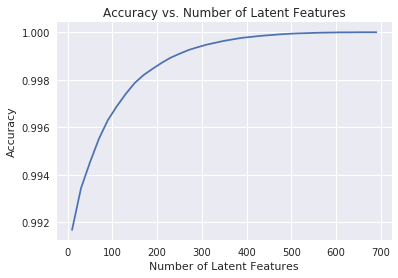

In [53]:
# call function

num_latent_feats = np.arange(10,700+10,20)

evaluate_SVD(u, s, vt, num_latent_feats)

In [54]:
# alternative option, calculated with accuracy_score from sk-learn

def evaluate_SVD_2(u, s, vt, num_latent_feats):
    '''
    INPUT:
    u, s, vt: (matrices), result of SVD on User-Item Matrix
    num_latent_feats: (iterable), number of latent features to keep
    
    OUTPUT:
    plot of accuracy vs. number of latent features
    '''
    
    sum_accs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        user_item_est_arr = np.array(user_item_est).reshape((user_item_matrix.size,1))
        user_item_matrix_arr = np.array(user_item_matrix).reshape((user_item_matrix.size,1))

        acc = accuracy_score(user_item_matrix_arr, user_item_est_arr)
        sum_accs.append(acc)


    plt.plot(num_latent_feats, sum_accs);  # not sure about this one, df.shape[0] in orig
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');

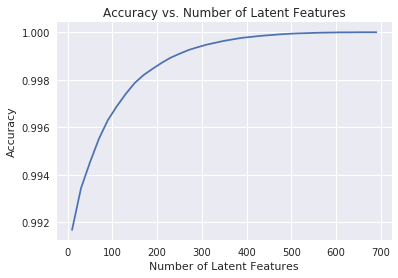

In [55]:
# call function

num_latent_feats = np.arange(10,700+10,20)

evaluate_SVD_2(u, s, vt, num_latent_feats)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [56]:
# split df into train and test sets

df_train = df.head(40000)
df_test = df.tail(5993)

In [57]:
# check result

df_test.head()

,article_id,title,user_id
40000,1053.0,access mysql with python,4487
40001,1314.0,healthcare python streaming application demo,4487
40002,1424.0,use spark for python to load data and run sql ...,4487
40003,1176.0,build a python app on the streaming analytics ...,4487
40004,58.0,advancements in the spark community,4488


In [58]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
#     user_item_train = df_train.copy()
#     user_item_train['title'] = 1
#     user_item = user_item.groupby(['user_id', 'article_id'])['title'].max().unstack()
#     user_item.fillna(value=0, inplace=True)

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = df_test['user_id']
    test_arts = df_test['article_id']    
    
    return user_item_train, user_item_test, test_idx, test_arts

In [59]:
# call the function

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [60]:
# Check - replace the values in the dictionary below

c = len(set(test_idx).intersection(set(df_train['user_id'])))
a = len(set(test_idx)) - c 
b = len(set(test_arts).intersection(set(df_train['article_id']))) 
d = len(set(test_arts)) - b

print(c, a, b, d, "\n")


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

20 662 574 0 

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [61]:
# create reduced test set
                           
df_test_red = df_test.loc[df_test['user_id'].isin(df_train['user_id'])]

# safety check

assert df_test_red['user_id'].nunique() == 20   

In [62]:
# create reduced test matrix, idx and arts lists

user_item_train, user_item_test_red, test_red_idx, test_red_arts = create_test_and_train_user_item(df_train, df_test_red)

In [63]:
# check result

user_item_test_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 2917 to 4487
Columns: 152 entries, 1006.0 to 996.0
dtypes: float64(152)
memory usage: 23.9 KB


In [64]:
# check for sparsity 

size_test = user_item_test_red.size
sum_test = user_item_test_red.sum().sum()
perc_test = (sum_test / size_test) * 100
print(sum_test, size_test, perc_test, " - about 7% of entries are ones")

218.0 3040 7.17105263158  - about 7% of entries are ones


In [65]:
def evaluate_SVD_test_set(user_item_train, user_item_test, num_latent_feats):
    '''
    INPUT:
    user_item_train - a user-item matrix of the training dataframe 
    user_item_test - a user-item matrix of the testing dataframe 
    num_latent_feats: (iterable), number of latent features to keep
    
    OUTPUT:
    plot of accuracy vs. number of latent features
    '''   
    
    test_rows = user_item_test.index
    test_cols = user_item_test.columns
    train_rows = user_item_train.index
    train_cols = user_item_train.columns
    
    # fit SVD on the user_item_train matrix
    u_train, s_train, vt_train = np.linalg.svd(user_item_train)
    
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # filter user_item_est to size of user_item_test
        est_df_full = pd.DataFrame(data=user_item_est, index=train_rows, columns=train_cols)
        est_df_red = est_df_full.loc[test_rows, test_cols]
        
        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_test, est_df_red)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)
    
#     return sum_errs

    # plot results
    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/user_item_test.size);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');

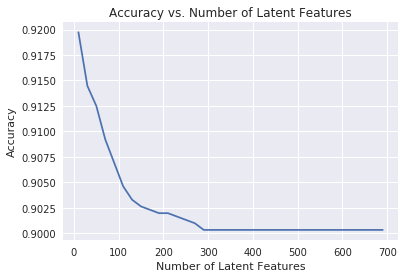

In [66]:
# call function

num_latent_feats = np.arange(10,700+10,20)

evaluate_SVD_test_set(user_item_train, user_item_test_red, num_latent_feats=num_latent_feats)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**ANSWER (Part 1):** Accuracy on the test set is decreasing from around 92 to 90% percent when we add more latent features. This could have to do with overfitting, but could also be misleading. General problem here is, that we have extremely skewed data and accuracy is a very bad metric in this situation.

Let's evaluate the results with F1-Score instead:

In [67]:
def evaluate_SVD_f1(user_item_train, user_item_test, num_latent_feats):
    '''
    INPUT:
        user_item_train - a user-item matrix of the training dataframe 
        user_item_test - a user-item matrix of the testing dataframe 
        num_latent_feats: (iterable), number of latent features to keep
    
    OUTPUT:
        plot of accuracy vs. number of latent features
    '''   
    
    test_rows = user_item_test.index
    test_cols = user_item_test.columns
    train_rows = user_item_train.index
    train_cols = user_item_train.columns
    
    # fit SVD on the user_item_train matrix
    u_train, s_train, vt_train = np.linalg.svd(user_item_train)
    
    scores = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # filter user_item_est to size of user_item_test
        est_df_full = pd.DataFrame(data=user_item_est, index=train_rows, columns=train_cols)
        est_df_red = est_df_full.loc[test_rows, test_cols]
        
        # compute f1-score
        user_item_test_arr = np.array(user_item_test).reshape((user_item_test.size, 1))
        user_item_est_arr = np.array(est_df_red).reshape((user_item_test.size, 1))

        # total errors and keep track of them
        f1 = f1_score(user_item_test_arr, user_item_est_arr)
        scores.append(f1)
    
#     return sum_errs

    # plot results
    plt.plot(num_latent_feats, scores);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('F1-Score');
    plt.title('F1-Score vs. Number of Latent Features');

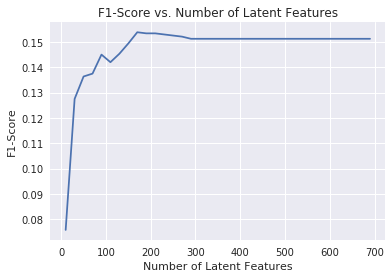

In [68]:
# call function

num_latent_feats = np.arange(10,700+10,20)

est_df_red = evaluate_SVD_f1(user_item_train, user_item_test_red, num_latent_feats=num_latent_feats)

**ANSWER (Part 2):** No This looks better, with adding more features the F1-Score rises sharply before we start to overfit at around 170 latent features. But the max F1-Score of about 15% is low. This means our model isn't that good at predicting acutal interactions according to our evaluation process on the test set.

Anyway - this doesn't necessarily mean, that the predictions the system makes are bad. Maybe the actual situation is so confusing that user don't find all relevant content and would be grateful for additional recommendations. We could find out by conducting A/B(/C) testing where some users get no recommendations at all, others geht recommendations by different kinds of recommender systems. Then we could measure general user engagement / clicks on recommended articles, etc.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [69]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0